In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array
import pickle

from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [5]:
def AddHist_data(file, hist,isbarrel,isData=True, xsec=1, lumi=1):
    
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches =[
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]  
    
    # --Complete branches (data) 
    if isData:
        print('is Data')
 
                
    # --Complete branches (MC)
    else:
        print('is MC')
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

                
                
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        print('SingleMuon trigger')
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        print('DoubleMuon trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        print('SingleElectron trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        print('MuonEG Trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        print('DoubleEG trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        print('isMC')
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

    print('after trigger',len(arrays))    
        
    
    # --cuts
    
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]
    print('after MET',len(arrays))
    
    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > 15)
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
    # bjet veto
    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
    arrays = arrays.loc[bjet_veto_mask,:]
    print('after bjet_veto',len(arrays))

    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
    
    mask_mediumID = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<9) | (1<<11) | (1<<13)
    
    # Original Photon MediumID 
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID, :]
    print('after Photon ID',len(arrays))
        
    # Photon PT
    pt_cut = (arrays.loc[:,'photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut & eta_cut ,:]
    print('after photon pt eta',len(arrays))
    
    # -- Fill hist
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:
        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight']*  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))
    
def AddHist_dataFake(file, hist,isbarrel,isData=True,xsec=1,lumi=1):
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ] 
    
    # --Complete branches (data) 
    if isData:
        print('is Data')

                
    # --Complete branches (MC)
    else:
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
    
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()
        
    
    # --cuts
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]

    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > 15)
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
    # bjet veto
    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
    arrays = arrays.loc[bjet_veto_mask,:]
    print('after bjet_veto',len(arrays))
    
    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)        
        
    # Photon IsoChg SB cut
    sb = [4,10]

    chg_cut = ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) > sb[0]) & ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) < sb[1])
    pt_cut  = (arrays.loc[:,'photon_pt'] >= 20)        
    
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut,:]
    
    
    # -- Fill hist
    
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:

        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight'] *  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))

In [6]:
## 2016 CR

filelist_data = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root"
]

In [7]:
filelist_MC = {
    
   "TTG":
        {"name":"TTGJets",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":4.078,
        },
   "TTZ":
        {"name":"TTZToLLNuNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2432,
        },
   "TTW":
        {"name":"TTWJetsToLNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":0.2149,
        },
   "tZq":
        {"name":"tZq_ll",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.07358,
        },
   "WWW":
        {"name":"WWW",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2086,
        },
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root",
        "xsec":55.48,
        },
    "ZZ":
        {"name":"ZZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root",
        "xsec":16.523, # NLO
        },
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root",
        "xsec":0.0384,
        },
   "WWZ":
        {"name":"WWZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.1707,
        },
   "ggZZ_2e2mu":
        {"name":"ggZZ2e2mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2e2nu":
#        {"name":"ggZZ2e2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2e2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2e2tau":
        {"name":"ggZZ2e2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2mu2nu":
#        {"name":"ggZZ2mu2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2mu2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2mu2tau":
        {"name":"ggZZ2mu2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
   "ggZZ_4e":
        {"name":"ggZZ4e",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4mu":
        {"name":"ggZZ4mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4tau":
        {"name":"ggZZ4tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        }    
}

In [8]:
from array import array



# Origin
xbins_EB = [20,30,50,80,120,180]
xbins_EE = [20,50,180]

# Tunning
#xbins_EB = [20,35,400]
#xbins_EE = [20,400]



isbarrel = 1 # barrel
#isbarrel = 0 # endcap


nbins=-1
if isbarrel == 1:
    xbins = xbins_EB
    nbins = len(xbins_EB) - 1
elif isbarrel ==0:
    xbins = xbins_EE
    nbins = len(xbins_EE) - 1
else:
    print("wrong!")
    
# Data template
hist_data = ROOT.TH1F("","",nbins,array('d',xbins))
hist_data.Sumw2()
# data
for file in filelist_data:
    AddHist_data(file, hist_data, isbarrel)   
# MC
for file in filelist_MC:
    AddHist_data(filelist_MC[file]['path'], hist_data,isbarrel,False,filelist_MC[file]['xsec'],35.86)                    

    
    
# --Fake template
hist_datafake = ROOT.TH1F("","",nbins,array('d',xbins))
hist_datafake.Sumw2()
# data
for file in filelist_data:
    AddHist_dataFake(file, hist_datafake,isbarrel,True)
# MC
for file in filelist_MC:
    AddHist_dataFake(filelist_MC[file]['path'], hist_datafake,isbarrel,False,filelist_MC[file]['xsec'],35.86)
    
    


is Data
DoubleEG trigger
after trigger 2150
after MET 666
after pt 124
after Zmass 36
after bjet_veto 34
after Photon ID 10
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 6/6 [00:00<00:00, 1494.50it/s]

is Data


DoubleEG trigger
after trigger 978
after MET 325
after pt 55
after Zmass 21
after bjet_veto 21
after Photon ID 8
after photon pt eta 5
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 5/5 [00:00<00:00, 38836.15it/s]

is Data


DoubleEG trigger
after trigger 1533
after MET 559
after pt 111
after Zmass 41
after bjet_veto 39
after Photon ID 7
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 6/6 [00:00<00:00, 26973.02it/s]

is Data


DoubleEG trigger
after trigger 1394
after MET 540
after pt 136
after Zmass 55
after bjet_veto 51
after Photon ID 15
after photon pt eta 10
events:  10


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 10/10 [00:00<00:00, 26346.13it/s]

is Data


DoubleEG trigger
after trigger 1194
after MET 461
after pt 62
after Zmass 16
after bjet_veto 15
after Photon ID 4
after photon pt eta 4
events:  4


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 4/4 [00:00<00:00, 15238.16it/s]

is Data


DoubleEG trigger
after trigger 3355
after MET 1376
after pt 371
after Zmass 150
after bjet_veto 141
after Photon ID 37
after photon pt eta 28
events:  28


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 28/28 [00:00<00:00, 85974.02it/s]

is Data


DoubleEG trigger
after trigger 3626
after MET 1570
after pt 372
after Zmass 156
after bjet_veto 151
after Photon ID 34
after photon pt eta 25
events:  25


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 25/25 [00:00<00:00, 93790.34it/s]

is Data


DoubleMuon trigger
after trigger 1617
after MET 560
after pt 108
after Zmass 24
after bjet_veto 23
after Photon ID 5
after photon pt eta 3
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 100%|██████████| 3/3 [00:00<00:00, 20627.72it/s]

is Data


DoubleMuon trigger
after trigger 708
after MET 256
after pt 103
after Zmass 16
after bjet_veto 14
after Photon ID 4
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 100%|██████████| 1/1 [00:00<00:00, 8405.42it/s]

is Data


DoubleMuon trigger
after trigger 1145
after MET 385
after pt 117
after Zmass 19
after bjet_veto 17
after Photon ID 4
after photon pt eta 3
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 3/3 [00:00<00:00, 10263.39it/s]

is Data


DoubleMuon trigger
after trigger 1120
after MET 436
after pt 179
after Zmass 34
after bjet_veto 34
after Photon ID 10
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 6/6 [00:00<00:00, 26630.50it/s]

is Data


DoubleMuon trigger
after trigger 912
after MET 360
after pt 143
after Zmass 26
after bjet_veto 25
after Photon ID 4
after photon pt eta 4
events:  4


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 4/4 [00:00<00:00, 28484.24it/s]

is Data


DoubleMuon trigger
after trigger 2478
after MET 1057
after pt 545
after Zmass 123
after bjet_veto 112
after Photon ID 28
after photon pt eta 22
events:  22


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 22/22 [00:00<00:00, 97233.60it/s]

is Data


DoubleMuon trigger
after trigger 2712
after MET 1146
after pt 519
after Zmass 117
after bjet_veto 109
after Photon ID 26
after photon pt eta 18
events:  18


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 18/18 [00:00<00:00, 57065.36it/s]

is Data


MuonEG Trigger
after trigger 181
after MET 122
after pt 63
after Zmass 10
after bjet_veto 6
after Photon ID 3
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 100%|██████████| 1/1 [00:00<00:00, 3923.58it/s]

is Data


MuonEG Trigger
after trigger 76
after MET 58
after pt 26
after Zmass 7
after bjet_veto 3
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger
after trigger 126
after MET 87
after pt 40
after Zmass 4
after bjet_veto 2
after Photon ID 2
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 100%|██████████| 1/1 [00:00<00:00, 4429.04it/s]

is Data


MuonEG Trigger
after trigger 133
after MET 90
after pt 39
after Zmass 5
after bjet_veto 3
after Photon ID 2
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 100%|██████████| 1/1 [00:00<00:00, 3123.09it/s]

is Data


MuonEG Trigger
after trigger 114
after MET 63
after pt 25
after Zmass 4
after bjet_veto 4
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger
after trigger 280
after MET 206
after pt 118
after Zmass 14
after bjet_veto 8
after Photon ID 3
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 2/2 [00:00<00:00, 8042.77it/s]

is Data


MuonEG Trigger
after trigger 276
after MET 196
after pt 78
after Zmass 12
after bjet_veto 8
after Photon ID 3
after photon pt eta 3
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 100%|██████████| 3/3 [00:00<00:00, 8689.86it/s]

is Data


SingleElectron trigger
after trigger 17501
after MET 6138
after pt 803
after Zmass 519
after bjet_veto 499
after Photon ID 120
after photon pt eta 90
events:  90


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 90/90 [00:00<00:00, 135397.19it/s]

is Data


SingleElectron trigger
after trigger 7197
after MET 2776
after pt 293
after Zmass 214
after bjet_veto 195
after Photon ID 44
after photon pt eta 29
events:  29


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 29/29 [00:00<00:00, 112002.59it/s]

is Data


SingleElectron trigger
after trigger 12090
after MET 4559
after pt 749
after Zmass 470
after bjet_veto 439
after Photon ID 97
after photon pt eta 70
events:  70


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 70/70 [00:00<00:00, 152361.85it/s]

is Data


SingleElectron trigger
after trigger 10390
after MET 4194
after pt 700
after Zmass 464
after bjet_veto 446
after Photon ID 92
after photon pt eta 67
events:  67


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 67/67 [00:00<00:00, 163477.82it/s]

is Data


SingleElectron trigger
after trigger 8234
after MET 3456
after pt 617
after Zmass 429
after bjet_veto 413
after Photon ID 103
after photon pt eta 78
events:  78


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 78/78 [00:00<00:00, 166491.46it/s]

is Data


SingleElectron trigger
after trigger 23451
after MET 9886
after pt 2116
after Zmass 1445
after bjet_veto 1372
after Photon ID 308
after photon pt eta 228
events:  228


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 228/228 [00:00<00:00, 143481.07it/s]

is Data


SingleElectron trigger
after trigger 26053
after MET 11373
after pt 2627
after Zmass 1797
after bjet_veto 1684
after Photon ID 331
after photon pt eta 242
events:  242


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 242/242 [00:00<00:00, 169142.07it/s]

is Data


SingleMuon trigger
after trigger 26828
after MET 9448
after pt 1782
after Zmass 1069
after bjet_veto 986
after Photon ID 257
after photon pt eta 192
events:  192


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 192/192 [00:00<00:00, 210813.19it/s]

is Data


SingleMuon trigger
after trigger 12592
after MET 4912
after pt 1359
after Zmass 788
after bjet_veto 733
after Photon ID 213
after photon pt eta 169
events:  169


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 169/169 [00:00<00:00, 210337.50it/s]

is Data


SingleMuon trigger
after trigger 20697
after MET 7969
after pt 1919
after Zmass 1111
after bjet_veto 1035
after Photon ID 241
after photon pt eta 177
events:  177


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 177/177 [00:00<00:00, 179365.02it/s]

is Data


SingleMuon trigger
after trigger 18656
after MET 7760
after pt 1568
after Zmass 901
after bjet_veto 843
after Photon ID 203
after photon pt eta 156
events:  156


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 156/156 [00:00<00:00, 178969.21it/s]

is Data


SingleMuon trigger
after trigger 14784
after MET 6263
after pt 1296
after Zmass 777
after bjet_veto 728
after Photon ID 191
after photon pt eta 133
events:  133


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 133/133 [00:00<00:00, 141369.09it/s]

is Data


SingleMuon trigger
after trigger 40818
after MET 17351
after pt 4978
after Zmass 2951
after bjet_veto 2746
after Photon ID 612
after photon pt eta 459
events:  459


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 459/459 [00:00<00:00, 127217.71it/s]

is Data


SingleMuon trigger
after trigger 47810
after MET 21097
after pt 5866
after Zmass 3533
after bjet_veto 3282
after Photon ID 748
after photon pt eta 544
events:  544


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 544/544 [00:00<00:00, 170798.82it/s]

is MC


isMC
after trigger 32620
after MET 29233
after pt 25874
after Zmass 4818
after bjet_veto 1623
after Photon ID 1243
after photon pt eta 1010
events:  1010


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 1010/1010 [00:00<00:00, 73417.22it/s]

is MC


isMC
after trigger 170133
after MET 139256
after pt 138880
after Zmass 82450
after bjet_veto 26878
after Photon ID 6398
after photon pt eta 4748
events:  4748


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 4748/4748 [00:00<00:00, 112307.30it/s]

is MC


isMC
after trigger 45760
after MET 41845
after pt 40997
after Zmass 7542
after bjet_veto 2525
after Photon ID 728
after photon pt eta 533
events:  533


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 533/533 [00:00<00:00, 93350.76it/s]

is MC


isMC
after trigger 129340
after MET 86420
after pt 85754
after Zmass 60320
after bjet_veto 27413
after Photon ID 6106
after photon pt eta 4490
events:  4490


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 4490/4490 [00:00<00:00, 127996.80it/s]


is MC
isMC
after trigger 148
after MET 134
after pt 29
after Zmass 2
after bjet_veto 2
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]

is MC


isMC
after trigger 3877650
after MET 1194133
after pt 1171627
after Zmass 432020
after bjet_veto 424289
after Photon ID 329358
after photon pt eta 255597
events:  255597


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 255597/255597 [00:02<00:00, 108546.12it/s]


is MC
isMC
after trigger 5896
after MET 2329
after pt 2027
after Zmass 1548
after bjet_veto 1431
after Photon ID 357
after photon pt eta 257
events:  257


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 257/257 [00:00<00:00, 104623.52it/s]

is MC


isMC
after trigger 23791
after MET 18780
after pt 18767
after Zmass 6395
after bjet_veto 6321
after Photon ID 5003
after photon pt eta 3917
events:  3917


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 3917/3917 [00:00<00:00, 93769.59it/s]

is MC


isMC
after trigger 572
after MET 457
after pt 351
after Zmass 192
after bjet_veto 188
after Photon ID 64
after photon pt eta 47
events:  47


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 47/47 [00:00<00:00, 74983.75it/s]

is MC


isMC
after trigger 287912
after MET 94017
after pt 93906
after Zmass 62940
after bjet_veto 62243
after Photon ID 44499
after photon pt eta 34074
events:  34074


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 34074/34074 [00:00<00:00, 114662.22it/s]


is MC
isMC
after trigger 36880
after MET 22389
after pt 22040
after Zmass 16321
after bjet_veto 16029
after Photon ID 4046
after photon pt eta 3208
events:  3208


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3208/3208 [00:00<00:00, 97407.79it/s]

is MC


isMC
after trigger 46554
after MET 27426
after pt 27076
after Zmass 22469
after bjet_veto 22094
after Photon ID 5027
after photon pt eta 3991
events:  3991


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3991/3991 [00:00<00:00, 113319.66it/s]

is MC


isMC
after trigger 448806
after MET 149564
after pt 149529
after Zmass 92167
after bjet_veto 91240
after Photon ID 65633
after photon pt eta 48968
events:  48968


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 48968/48968 [00:00<00:00, 109151.39it/s]


is MC
isMC
after trigger 723069
after MET 229703
after pt 229263
after Zmass 154925
after bjet_veto 153190
after Photon ID 108751
after photon pt eta 92831
events:  92831


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 92831/92831 [00:00<00:00, 116187.44it/s]


is MC
isMC
after trigger 3672
after MET 2433
after pt 1715
after Zmass 271
after bjet_veto 268
after Photon ID 67
after photon pt eta 53
events:  53


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 53/53 [00:00<00:00, 81012.43it/s]

is Data


after pt 124
after Zmass 36
after bjet_veto 34
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 5/5 [00:00<00:00, 35305.59it/s]

is Data


after pt 55
after Zmass 21
after bjet_veto 21
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 3/3 [00:00<00:00, 26105.63it/s]

is Data


after pt 111
after Zmass 41
after bjet_veto 39
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 5/5 [00:00<00:00, 32513.98it/s]

is Data


after pt 136
after Zmass 55
after bjet_veto 51
events:  8


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 8/8 [00:00<00:00, 49636.73it/s]

is Data


after pt 62
after Zmass 16
after bjet_veto 15
events:  4


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 4/4 [00:00<00:00, 21816.93it/s]

is Data


after pt 371
after Zmass 150
after bjet_veto 141
events:  12


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 12/12 [00:00<00:00, 70393.91it/s]

is Data


after pt 372
after Zmass 156
after bjet_veto 151
events:  30


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 30/30 [00:00<00:00, 43240.25it/s]

is Data


after pt 108
after Zmass 24
after bjet_veto 23
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 0it [00:00, ?it/s]

is Data


after pt 103
after Zmass 16
after bjet_veto 14
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 100%|██████████| 2/2 [00:00<00:00, 18641.35it/s]

is Data


after pt 117
after Zmass 19
after bjet_veto 17
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 3/3 [00:00<00:00, 27235.74it/s]

is Data


after pt 179
after Zmass 34
after bjet_veto 34
events:  7


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 7/7 [00:00<00:00, 43432.14it/s]

is Data


after pt 143
after Zmass 26
after bjet_veto 25
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 2/2 [00:00<00:00, 19284.16it/s]

is Data


after pt 545
after Zmass 123
after bjet_veto 112
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 14/14 [00:00<00:00, 87904.57it/s]

is Data


after pt 519
after Zmass 117
after bjet_veto 109
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 14/14 [00:00<00:00, 87642.17it/s]

is Data


after pt 63
after Zmass 10
after bjet_veto 6
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


after pt 26
after Zmass 7
after bjet_veto 3
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


after pt 40
after Zmass 4
after bjet_veto 2
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


after pt 39
after Zmass 5
after bjet_veto 3
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


after pt 25
after Zmass 4
after bjet_veto 4
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 100%|██████████| 2/2 [00:00<00:00, 9208.13it/s]

is Data


after pt 118
after Zmass 14
after bjet_veto 8
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]

is Data


after pt 78
after Zmass 12
after bjet_veto 8
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


after pt 803
after Zmass 519
after bjet_veto 499
events:  69


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 69/69 [00:00<00:00, 142917.03it/s]

is Data


after pt 293
after Zmass 214
after bjet_veto 195
events:  25


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 25/25 [00:00<00:00, 109569.07it/s]

is Data


after pt 749
after Zmass 470
after bjet_veto 439
events:  54


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 54/54 [00:00<00:00, 148617.07it/s]

is Data


after pt 700
after Zmass 464
after bjet_veto 446
events:  62


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 62/62 [00:00<00:00, 158468.52it/s]

is Data


after pt 617
after Zmass 429
after bjet_veto 413
events:  66


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 66/66 [00:00<00:00, 153195.39it/s]

is Data


after pt 2116
after Zmass 1445
after bjet_veto 1372
events:  200


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 200/200 [00:00<00:00, 164611.62it/s]

is Data


after pt 2627
after Zmass 1797
after bjet_veto 1684
events:  232


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 232/232 [00:00<00:00, 183253.96it/s]

is Data


after pt 1782
after Zmass 1069
after bjet_veto 986
events:  139


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 139/139 [00:00<00:00, 166859.83it/s]

is Data


after pt 1359
after Zmass 788
after bjet_veto 733
events:  110


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 110/110 [00:00<00:00, 172540.55it/s]

is Data


after pt 1919
after Zmass 1111
after bjet_veto 1035
events:  147


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 147/147 [00:00<00:00, 152955.27it/s]

is Data


after pt 1568
after Zmass 901
after bjet_veto 843
events:  111


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 111/111 [00:00<00:00, 141941.39it/s]

is Data


after pt 1296
after Zmass 777
after bjet_veto 728
events:  83


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 83/83 [00:00<00:00, 137654.11it/s]

is Data


after pt 4978
after Zmass 2951
after bjet_veto 2746
events:  388


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 388/388 [00:00<00:00, 102075.52it/s]

is Data


after pt 5866
after Zmass 3533
after bjet_veto 3282
events:  479


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 479/479 [00:00<00:00, 198898.29it/s]


after pt 25874
after Zmass 4818
after bjet_veto 1623
events:  50


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 50/50 [00:00<00:00, 73843.38it/s]


after pt 138880
after Zmass 82450
after bjet_veto 26878
events:  3643


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 3643/3643 [00:00<00:00, 118882.50it/s]


after pt 40997
after Zmass 7542
after bjet_veto 2525
events:  303


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 303/303 [00:00<00:00, 101483.20it/s]


after pt 85754
after Zmass 60320
after bjet_veto 27413
events:  3356


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 3356/3356 [00:00<00:00, 116152.73it/s]


after pt 29
after Zmass 2
after bjet_veto 2
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]


after pt 1171627
after Zmass 432020
after bjet_veto 424289
events:  10085


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 10085/10085 [00:00<00:00, 116825.40it/s]


after pt 2027
after Zmass 1548
after bjet_veto 1431
events:  191


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 191/191 [00:00<00:00, 70408.86it/s]


after pt 18767
after Zmass 6395
after bjet_veto 6321
events:  114


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 114/114 [00:00<00:00, 90593.15it/s]


after pt 351
after Zmass 192
after bjet_veto 188
events:  24


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 24/24 [00:00<00:00, 63111.78it/s]


after pt 93906
after Zmass 62940
after bjet_veto 62243
events:  1514


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 1514/1514 [00:00<00:00, 112354.72it/s]


after pt 22040
after Zmass 16321
after bjet_veto 16029
events:  3286


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3286/3286 [00:00<00:00, 118385.87it/s]


after pt 27076
after Zmass 22469
after bjet_veto 22094
events:  4865


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 4865/4865 [00:00<00:00, 99719.44it/s]


after pt 149529
after Zmass 92167
after bjet_veto 91240
events:  1827


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 1827/1827 [00:00<00:00, 93978.33it/s]


after pt 229263
after Zmass 154925
after bjet_veto 153190
events:  4393


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 4393/4393 [00:00<00:00, 111227.95it/s]


after pt 1715
after Zmass 271
after bjet_veto 268
events:  54


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 54/54 [00:00<00:00, 49066.81it/s]


35.86 fb^{-1} (13 TeV)


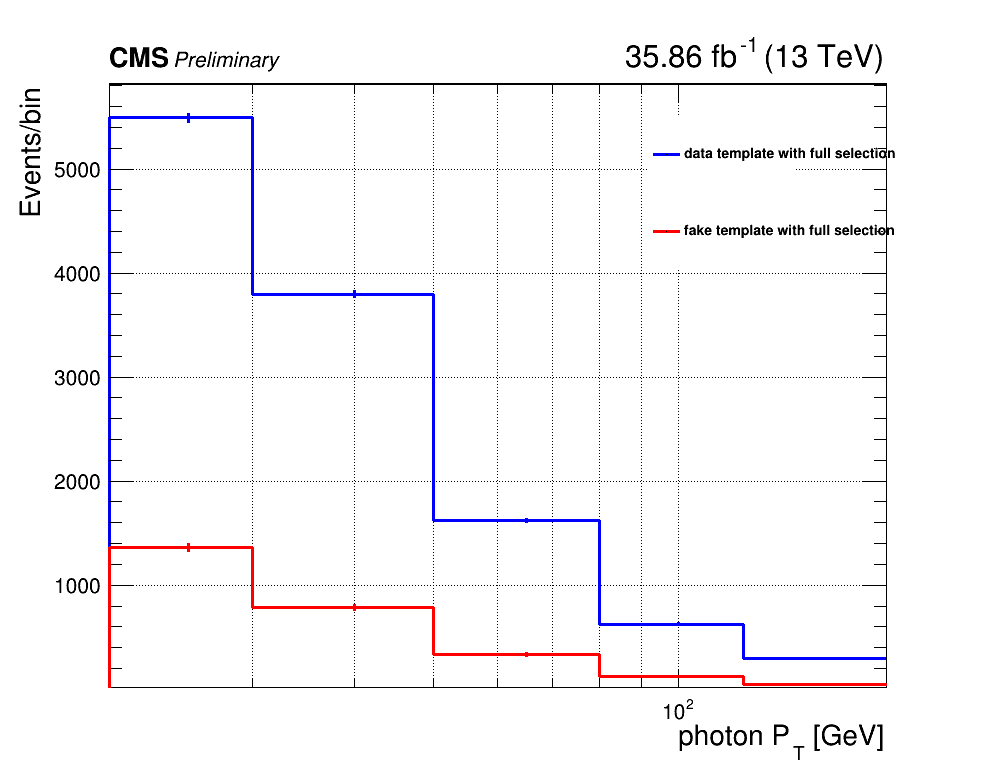

In [9]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()

hist_data.GetXaxis().SetTitle("photon P_{T} [GeV]")
hist_data.GetYaxis().SetTitle("Events/bin")
hist_data.SetMarkerStyle(0)
hist_data.SetLineColor(4)
hist_data.SetLineWidth(3)
hist_data.Draw("HIST e")



hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HIST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template with full selection')
legend.AddEntry(hist_datafake,'fake template with full selection')
legend.Draw("SAME")




ROOT.gPad.SetLogx()
ROOT.gPad.SetGrid()

CMS_lumi(c1,0,0)

### Calculate FakeWeight

In [10]:
file1 = ROOT.TFile("DataTemplate_EB_data.root","recreate")
file1.cd()
hist_data.Write()
file1.Close()

file2 = ROOT.TFile("FakeTemplate_EB_fake.root","recreate")
file2.cd()
hist_datafake.Write()
file2.Close()

!ls

2016				    images
2017				    log.csv
2018				    Lumi.py
a				    MagicDraw
Combined_plot_2016.ipynb	    Merged_file
Combined_plot_FakeLepton2016.ipynb  Merged_file_211028
Combined_plot.ipynb		    Merged_file_FakePhoton_211128
Combined_plot_SR2016.ipynb	    Mu_Fake_Rate_2D_2016.root
Combined_plot_ZZ2016.ipynb	    npy_dict
DataTemplate_EB_data.root	    pickle_dict
DataTemplate_EE_data.root	    pickle_dict_sample
Electron_channel		    __pycache__
Ele_Fake_Rate_2D_2016.root	    Ratio_Plot.py
fakefraction_real.csv		    results_2016
FakeLepton2016_Ele.ipynb	    Scale_PDF_Unc.ipynb
FakeLepton2016_Mu.ipynb		    TDR_Style.py
FakeLepton2017_Ele.ipynb	    Template_Fit_2016.ipynb
FakeLepton2018_Ele.ipynb	    Template_Fit_AR_2017.ipynb
FakeLepton_SingleEle_check.ipynb    Template_Fit_AR_2018.ipynb
FakePhoton_2017-2018_hist_ref	    Template_Fit.ipynb
FakeTemplate_EB_fake.root	    Test_Fit.ipynb
FakeTemplate_EE_fake.root	    WZG_sample
FakeWeight_2016.ipynb		    Yeop_test.ipynb


In [11]:
fake_fraction_2016 = {"Barrel":[0.293,0.228,0.233,0.175,0.152],
                    "Endcap":[0.434,0.29]}

In [12]:
for i in range(1,hist_data.GetNbinsX()+1):
    
    ydata= hist_data.GetBinContent(i)
    yfake= hist_datafake.GetBinContent(i)
    
    j = i-1

    if isbarrel == 1:
        fake_fraction = fake_fraction_2016['Barrel'][j]
    elif isbarrel ==0:
        fake_fraction = fake_fraction_2016['Endcap'][j]
    
    
    if (ydata == 0) or (yfake == 0):
        ratio = 0
    else:
        ratio = ydata / yfake
    
    fake_weight = ratio * fake_fraction
    print("{0}th  ydata: {1} yfake:  {2} ydata/yfake: {3:.2f} fake fraction: {4} fake weight: {5:.2f}".format(i,ydata,yfake,ratio,fake_fraction,fake_weight))

1th  ydata: 5490.61962890625 yfake:  1361.936279296875 ydata/yfake: 4.03 fake fraction: 0.293 fake weight: 1.18
2th  ydata: 3796.360107421875 yfake:  787.2744140625 ydata/yfake: 4.82 fake fraction: 0.228 fake weight: 1.10
3th  ydata: 1621.7794189453125 yfake:  332.2588806152344 ydata/yfake: 4.88 fake fraction: 0.233 fake weight: 1.14
4th  ydata: 626.3883056640625 yfake:  120.78445434570312 ydata/yfake: 5.19 fake fraction: 0.175 fake weight: 0.91
5th  ydata: 292.6216125488281 yfake:  44.704856872558594 ydata/yfake: 6.55 fake fraction: 0.152 fake weight: 0.99


---

---